In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [40]:
# Parameters
L = 1.0
E0 = 1.0
N = 50
h = L / (N - 1)

# Symbolic variables
alpha = ca.MX.sym("alpha", N)
#y = ca.MX.sym("y", N)
k = ca.MX.sym("k")   # curvature
ell = ca.MX.sym("ell")   # internal length
Z = ca.vertcat(alpha)
gamma = 2.0
k_res = 1.0e-5

def a(alpha,gamma=gamma,k_res=k_res):
    return (1-alpha)/(1+(gamma-1)*alpha)**2 +k_res
    
def w(alpha):
    return 1- (1-alpha)**2
# Constraints
#constraints = []
#for i in range(N - 1):
#    constraints.append((alpha[i+1]) / h - ca.cos(theta[i]))
##    constraints.append((y[i+1] - y[i]) / h - ca.sin(theta[i]))
#constraints.append(theta[0])
#constraints.append(x[0])
#constraints.append(y[0])
#g = ca.vertcat(*constraints)

x = np.linspace(0, L, N)
w_1 = 1.0 
# Energy
elastic = sum(0.5 * E0 * a(alpha[i]) * (1.0-x[i]) **2 *k**2* h for i in range(N - 1))
dissipated = sum(w_1* ( w(alpha[i]) + ell**2 * ((alpha[i+1]-alpha[i])/h)**2)* h for i in range(N - 1))
total_energy = elastic + dissipated

# Problem
params = ca.vertcat(k, ell)
nlp = {"x": alpha, "p": params, "f": total_energy, "g": [0]}
opts = {"ipopt": {"print_level": 0, "tol": 1e-8, "linear_solver": "mumps","sb": "yes"},"print_time": False}
solver = ca.nlpsol("solver", "ipopt", nlp, opts)

In [52]:
load_values = np.linspace(0, 3, 50) 
alpha_0 = 0.0 * np.sin(np.linspace(0, np.pi, N))  # Perturbation
print(alpha_0)
alphas = []
ell_val= 0.1
lbx = alpha_0         # lower bounds
ubx = np.ones_like(alpha_0)      # upper bounds (or some upper value if needed)
threshold = 1e-6

for k_val in load_values:
    lbx = np.minimum(alpha_0, 0.999)
    sol = solver(x0=alpha_0, p=[k_val, ell_val], lbg=0, ubg=0, lbx=lbx, ubx=ubx)
    stats = solver.stats()
    alpha_opt = sol['x'].full().flatten()
    print(f"Load={k_val:.3f} | alpha_max: {max(alpha_opt)}| Status={stats['return_status']} | N:Iterations={stats['iter_count']}")
    alpha_0 = alpha_opt
    alphas.append(alpha_opt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Load=0.000 | alpha_max: 6.242298216621342e-05| Status=Solve_Succeeded | N:Iterations=12
Load=0.061 | alpha_max: 9.898369684676399e-05| Status=Solve_Succeeded | N:Iterations=12
Load=0.122 | alpha_max: 0.00012506091458281717| Status=Solve_Succeeded | N:Iterations=12
Load=0.184 | alpha_max: 0.00014543556536388266| Status=Solve_Succeeded | N:Iterations=12
Load=0.245 | alpha_max: 0.00016222517059956055| Status=Solve_Succeeded | N:Iterations=12
Load=0.306 | alpha_max: 0.00017655363080367438| Status=Solve_Succeeded | N:Iterations=12
Load=0.367 | alpha_max: 0.00018908876223204226| Status=Solve_Succeeded | N:Iterations=12
Load=0.429 | alpha_max: 0.00020025953148326457| Status=Solve_Succeeded | N:Iterations=12
Load=0.490 | alpha_max: 0.000210357722951732| Status=Solve_Succeeded | N:Iterations=12
Load=0.551 | alpha_max: 0.00021959073239483204| S

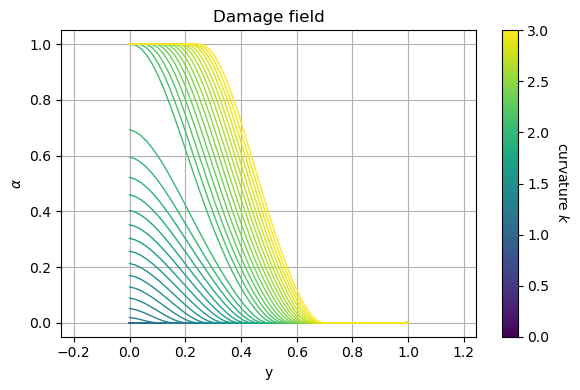

In [55]:
# Plot shapes
cmap = cm.viridis
norm = mcolors.Normalize(vmin=load_values[0], vmax=load_values[-1])
fig, ax = plt.subplots(figsize=(6, 4))
for i, alpha_ in enumerate(alphas):
    ax.plot(x, alpha_, color=cmap(norm(load_values[i])), linewidth=1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("curvature $k$", rotation=270, labelpad=15)
ax.set_xlabel("y")
ax.set_ylabel(r"$\alpha$")
ax.set_title("Damage field")
ax.axis("equal")
ax.grid(True)
plt.tight_layout()
plt.show()